In [ ]:
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np

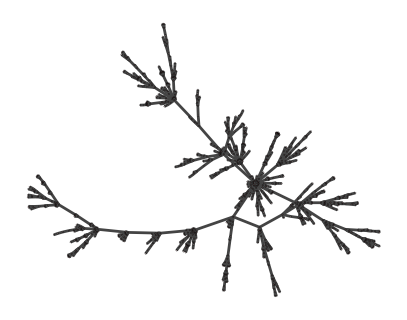

In [ ]:
g2_2 = ig.Graph.Barabasi(900, 1, directed=False)
fig, ax = plt.subplots(figsize=(5,5))
ig.plot(
    g2_2,
    target=ax
)
plt.show()

## 2.2 Random walk on networks with fat-tailed degree distribution

N = 900


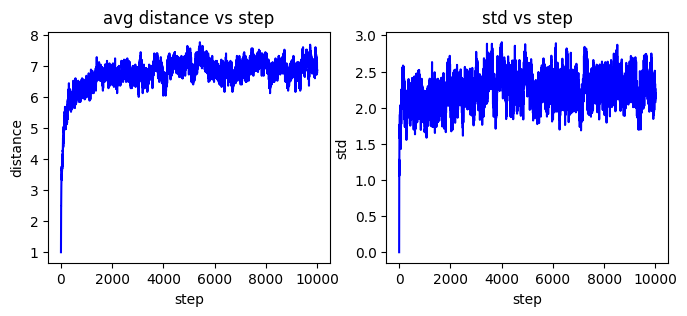

N = 90


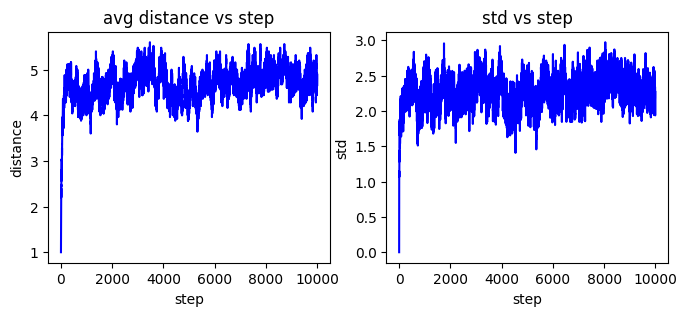

N = 9000


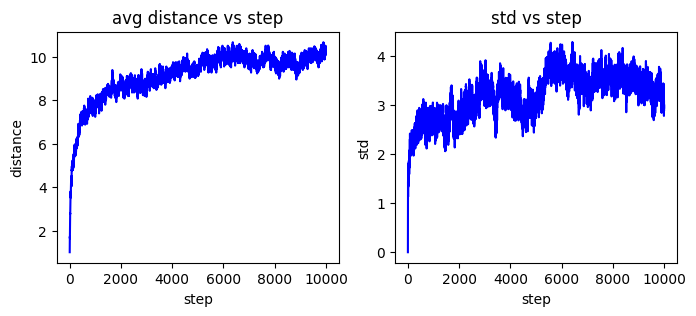

In [ ]:
T = 500   # walk T times
S = 10000  # each walk, walk step S
for N in [900, 90, 9000]:
    g2_2 = ig.Graph.Barabasi(N, 1, directed=False)
    starter = np.random.randint(0, N-1, size=(T,))  # T random starter
    distances = np.zeros((T, S))  # dim 0 is different walk, dim 1 is step
    # walk T times
    for i in range(T):
        rst = g2_2.random_walk(g2_2.vs[starter[i]], S)[1:]
        paths = g2_2.get_shortest_paths(g2_2.vs[starter[i]], rst, mode='all')
        distance = []
        for j in range(S):
            distance.append(len(paths[j])-1)
        distances[i] = np.array(distance)
    
    avg_distance = np.mean(distances, axis=0)
    std = np.std(distances, axis=0)

    print(f"N = {N}")

    plt.figure(figsize=(8,3))
    plt.subplot(121)
    plt.title('avg distance vs step')
    plt.plot(range(S), avg_distance, color="blue")
    plt.xlabel('step')
    plt.ylabel('distance')

    plt.subplot(122)
    plt.title('std vs step')
    plt.plot(range(S), std, color="blue")
    plt.xlabel('step')
    plt.ylabel('std')
    plt.show()


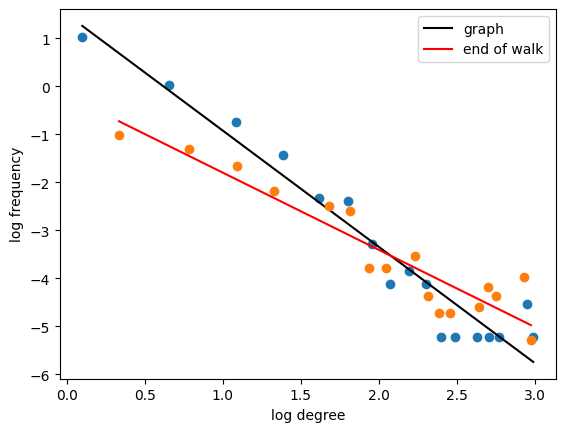

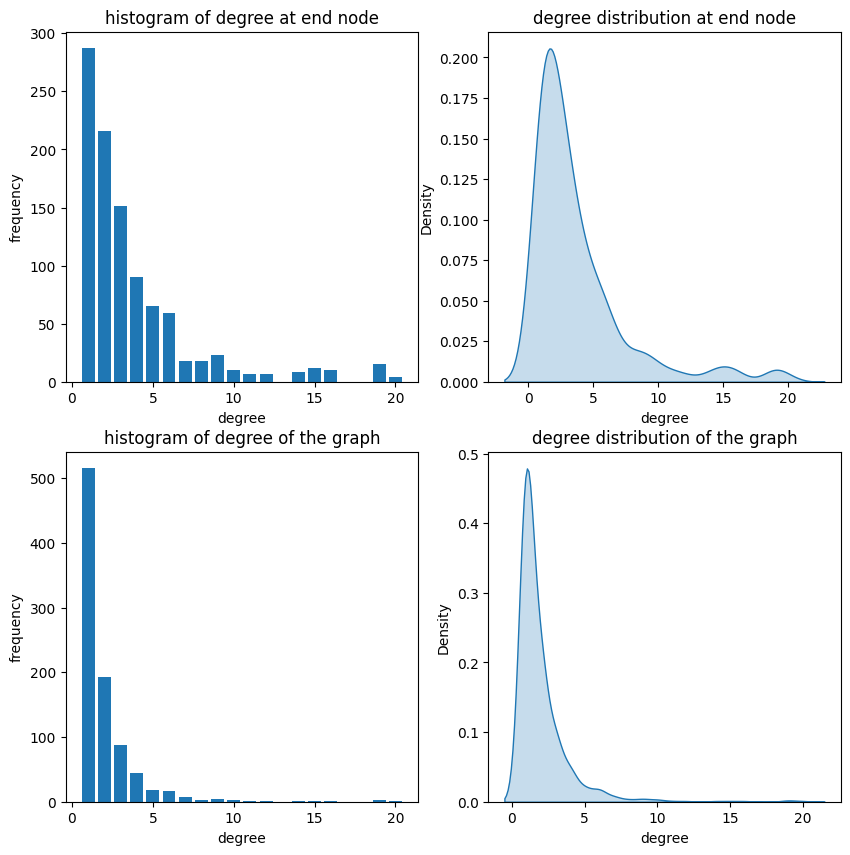

In [ ]:
N = 900
g2_2 = ig.Graph.Barabasi(N, 1, directed=False)
# walk
T = 1000
S = 100
starter = np.random.randint(0, N-1, size=(T,))  # T random starter
rst2_2 = []
for i in range(T):
    # walk T times, add last node degree to rst
    rst = g2_2.random_walk(g2_2.vs[starter[i]], S)
    rst2_2.append(g2_2.degree(rst[-1]))
degrees = g2_2.degree()

def plot_loglogdistribution(data, color, label):
    frequency, bin_edges = np.histogram(data, bins='auto', density=True)

    non_zero_indices = frequency > 0
    frequency = frequency[non_zero_indices]
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_centers = bin_centers[non_zero_indices]

    bin_centers = np.log(bin_centers)
    frequency = np.log(frequency)

    plt.plot(bin_centers, frequency, marker='o', linestyle='none')

    para = np.polyfit(bin_centers, frequency, 1)
    p = np.poly1d(para)
    plt.plot(bin_centers, p(bin_centers), color=color, label=label)

plot_loglogdistribution(degrees, 'black', 'graph')
plot_loglogdistribution(rst2_2, 'red', 'end of walk')
plt.xlabel('log degree')
plt.ylabel('log frequency')
plt.legend()
plt.show()

import seaborn as sns
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('histogram of degree at end node')
plt.hist(rst2_2, bins=range(min(rst2_2), max(rst2_2)+2), 
                       align='left', rwidth=0.8, density=False)
plt.xlabel('degree')
plt.ylabel('frequency')

plt.subplot(222)
plt.title('degree distribution at end node')
sns.kdeplot(rst2_2, fill=True)
plt.xlabel('degree')

plt.subplot(223)
plt.title('histogram of degree of the graph')
plt.hist(degrees, bins=range(min(degrees), max(degrees)+2), 
                       align='left', rwidth=0.8, density=False)
plt.xlabel('degree')
plt.ylabel('frequency')

plt.subplot(224)
plt.title('degree distribution of the graph')
sns.kdeplot(degrees, fill=True)
plt.xlabel('degree')

plt.show()

## 2.3(a) page rank

In [ ]:
# generate page rank graph
N = 900
g2_3 = ig.Graph.Barabasi(N, 4, directed=True)  # first graph
g2_3_bak = ig.Graph.Barabasi(N, 4, directed=True)  # second graph
edges = np.array(g2_3_bak.get_edgelist())  # second graph edges
shuffle_map = np.arange(N)
np.random.shuffle(shuffle_map)  # shuffle second graph vertices
add_edges = shuffle_map[edges]  # edges to be added
g2_3.add_edges(add_edges)  # add to first graph

# walk
T = 1000
starter = np.random.randint(0, N-1, size=(T,))  # T random starter
rst2_3a = []
for i in range(T):
    # walk T times, add visited vertice to rst, except for the starter
    rst2_3a.append(g2_3.random_walk(g2_3.vs[starter[i]], T)[1:])

# print("nums of visited vertices is", len(rst))

In [ ]:
def analyze(rst_ori, g, observe='all', mode='in-degree', **kwargs):    
    N = g.vcount()
    rst = []
    for r in rst_ori:
        if observe == "all":
            rst += r
        if observe == 'last':
            rst.append(r[-1])
    print("nums of visited vertices is", len(rst))

    # calculate probability of visited
    from collections import Counter
    visit_counter = Counter(rst)
    p_visited = np.zeros(N)
    for i in range(N):
        p_visited[i] = visit_counter[i]
    p_visited /= len(rst)
    # 8 max
    print("8 top visit probability index", np.argsort(p_visited)[::-1][:8])

    # get metric
    if mode == "degree":
        metric = np.array(g.degree(mode='all'))
    elif mode == "in-degree":
        metric = np.array(g.degree(mode='in'))
    elif mode == "pagerank":
        metric = np.array(ig.Graph.pagerank(g, damping=0.8))
    elif mode == "personalized_pagerank":
        metric = np.array(ig.Graph.personalized_pagerank(g, damping=0.8, 
                                        reset_vertices=kwargs['nodes']))
    else:
        metric = mode
    # 8 max
    print(f"8 top {mode} index", np.argsort(metric)[::-1][:8])

    # compute correlation
    import scipy.stats as stats
    print(stats.pearsonr(p_visited, metric))  # Correlation
    print(stats.pearsonr(p_visited, metric**2))  # Correlation

    # plot visit probability and in-degree
    plt.figure(figsize=(9,4))
    plt.subplot(121)
    plt.title('visiting probability vs vertex index')
    plt.xlabel('vertex index')
    plt.ylabel('visiting probability')
    plt.scatter(range(N), p_visited, color="black", facecolors='none')
    plt.subplot(122)
    plt.xlabel('vertex index')
    plt.ylabel(mode)
    plt.title(f'{mode} vs vertex index')
    plt.scatter(range(N), metric, color="black", facecolors='none')
    plt.show()
    
    # plot in_degree vs p_visited
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.scatter(metric, p_visited, color="black", facecolors='none')
    plt.title(f'visiting probability vs {mode}')
    plt.xlabel(mode)
    plt.ylabel('visiting probability')
    para = np.polyfit(metric, p_visited, 1)
    p = np.poly1d(para)
    x = np.arange(100) / 100 * np.max(metric)
    plt.xlabel(f'vertex {mode}')

    plt.plot(x, p(x), color='r')
    # plt.subplot(132)
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.scatter(metric, p_visited, color="black", facecolors='none')
    for i in range(50):
        mask = np.where(metric==i, 1, 0)
        count = np.sum(mask)
        if count == 0:
            continue
        p = np.sum(mask * p_visited) / count
        p_visited = p_visited * (1-mask) + p * mask
    plt.subplot(122)
    plt.title(f'log visiting probability vs log {mode}')
    plt.xlabel(f"log {mode}")
    plt.ylabel('log visiting probability')
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(metric, p_visited, color="black", facecolors='none')
    plt.show()

nums of visited vertices is 1000000
8 top visit probability index [  0   1 718 190 160   2 678   4]
8 top in-degree index [160 718 678   0   2 190   3   1]
PearsonRResult(statistic=0.8888178644637991, pvalue=1.4299039438334747e-306)
PearsonRResult(statistic=0.8954592580581745, pvalue=6.699313e-318)


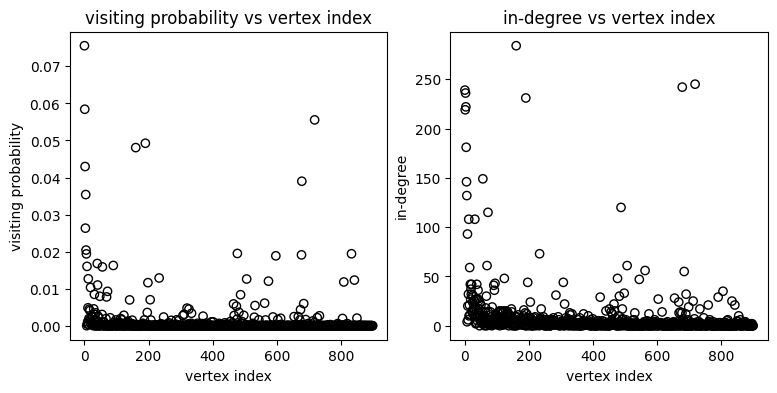

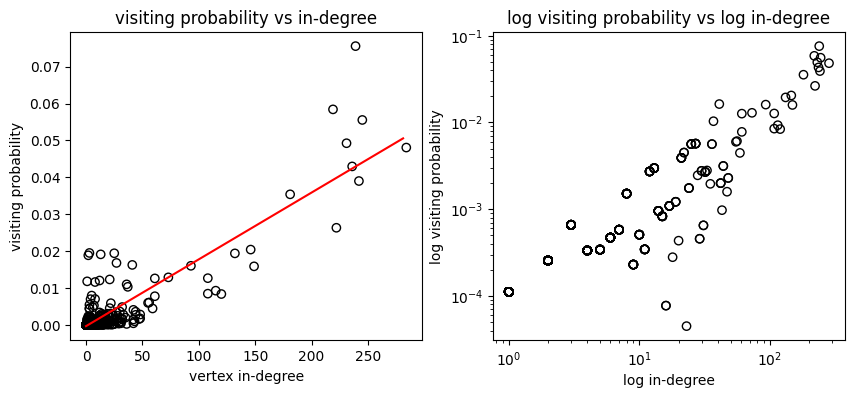

In [ ]:
analyze(rst2_3a, g2_3)

## 2.3(b) page rank with teleportation

In [ ]:
import random
def get_transition_probs(g):
    N = g.vcount()
    # generate transition probs 
    transition_probs = [[0] * N for i in range(N)]
    for i in range(N):
        neighbors = g.neighbors(i, mode='out')
        assert len(neighbors) > 0
        for j in neighbors:
            transition_probs[i][j] = 1.0 / g.degree(i, mode='out')
    return transition_probs

def escapable_random_walk(transition_probs, start=0, T=1000, pout=0.2):
    # walk T times
    rst = [start]
    current_node = start
    for i in range(T):
        if random.random() < pout:
            return rst
        else:
            probs = transition_probs[current_node]
            next_node = random.choices(range(N), probs)[0]
            current_node = next_node
            rst.append(current_node)
    return rst

# walk with prob of teleportation
T = 1000
pout = 0.2
transition_probs = get_transition_probs(g2_3)
starter = np.random.randint(0, N-1, size=(T,))  # T random starter
rst2_3b = []
for i in range(T):
    # walk T times, add visited vertice to rst, except for the starter
    rst2_3b.append(escapable_random_walk(transition_probs, 
                                         starter[i], T, pout)[1:])

nums of visited vertices is 3744
8 top visit probability index [  0 190   1 718 160   2 678   4]
8 top in-degree index [160 718 678   0   2 190   3   1]
PearsonRResult(statistic=0.9220549838940121, pvalue=0.0)
PearsonRResult(statistic=0.9175156376616459, pvalue=0.0)


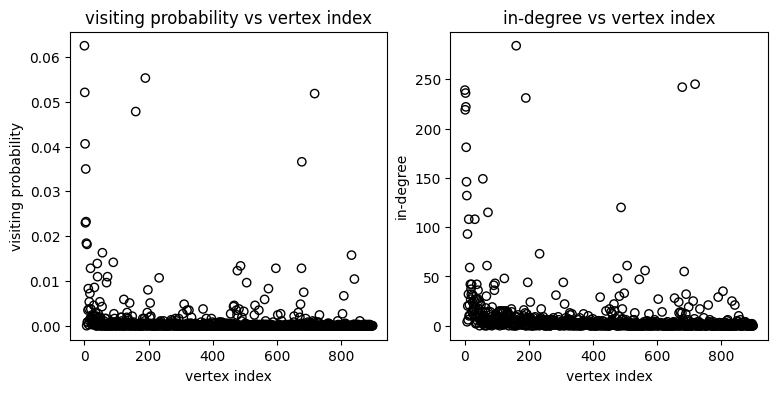

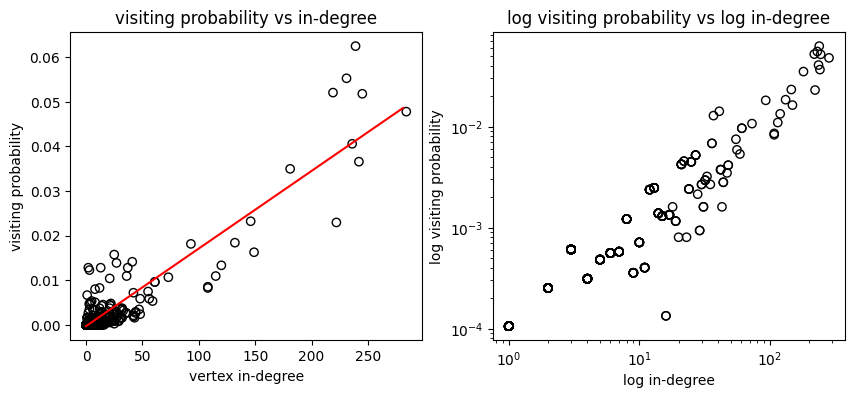

In [ ]:
analyze(rst2_3b, g2_3)


## 2.4(a) personalized page rank with teleportation

In [ ]:
def pagerank_transition_probs(g):
    N = g.vcount()
    pagerank_score = ig.Graph.pagerank(g, damping=0.8)
    # generate transition probs 
    transition_probs = [[0] * N for i in range(N)]
    for i in range(N):
        neighbors = g.neighbors(i, mode='out')
        assert len(neighbors) > 0
        for j in neighbors:
            transition_probs[i][j] = pagerank_score[j]
    return transition_probs

def personalized_random_walk(transition_probs, start=0, T=1000, pout=0.2):
    # walk T times
    rst = [start]
    current_node = start
    for i in range(T):
        if random.random() < 0.2:
            next_node = random.randint(0, N-1)
        else:
            probs = transition_probs[current_node]
            next_node = random.choices(range(N), probs)[0]
        current_node = next_node
        rst.append(current_node)
    return rst

# walk with prob of teleportation
g2_4 = g2_3
T = 1000
pout = 0.2
per_transition_probs = pagerank_transition_probs(g2_4)
starter = np.random.randint(0, N-1, size=(T,))  # T random starter
rst2_4a = []
for i in range(T):
    # walk T times, add visited vertice to rst, except for the starter
    rst2_4a.append(personalized_random_walk(per_transition_probs, 
                                            starter[i], T, pout)[1:])

nums of visited vertices is 1000000
8 top visit probability index [  0   1 718 160 190   2 678 833]
8 top in-degree index [160 718 678   0   2 190   3   1]
PearsonRResult(statistic=0.7827898142368064, pvalue=3.4229463025408105e-187)
PearsonRResult(statistic=0.8558362156230159, pvalue=2.4736446159898796e-259)


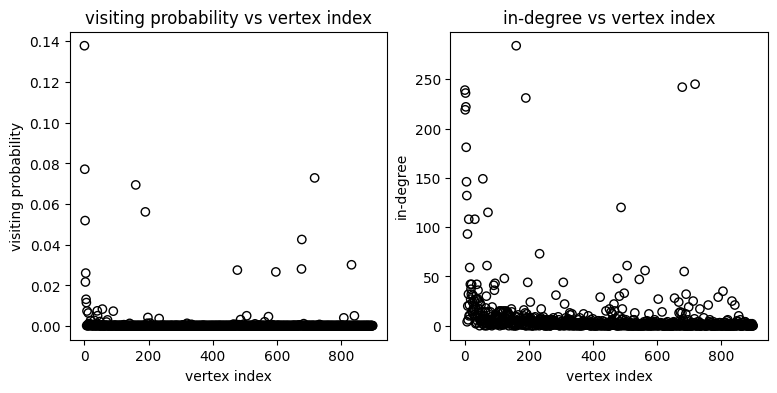

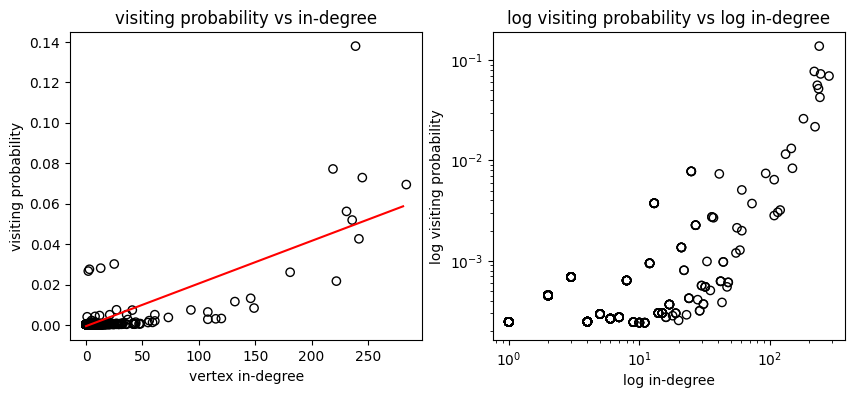

nums of visited vertices is 1000000
8 top visit probability index [  0   1 718 160 190   2 678 833]
8 top pagerank index [  0   1 718 160 190   2 678   4]
PearsonRResult(statistic=0.9273621943529592, pvalue=0.0)
PearsonRResult(statistic=0.9756978690301515, pvalue=0.0)


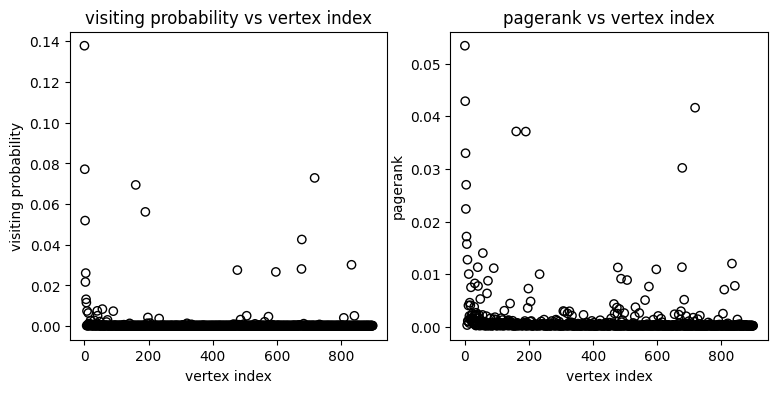

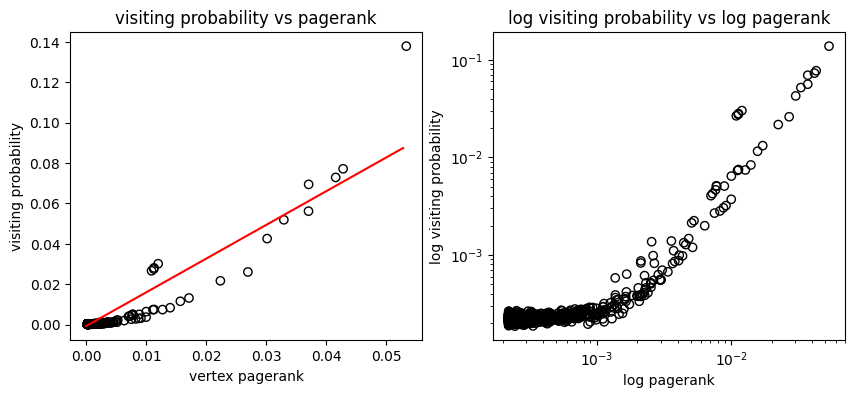

In [ ]:
analyze(rst2_4a, g2_4)
analyze(rst2_4a, g2_4, mode='pagerank')

## 2.4(b) teleportation to only two nodes

In [ ]:
def personalized_random_walk_2(transition_probs, start=0, T=1000, 
                               pout=0.2, outnodes=[0,1]):
    # teleport to only two nodes
    # walk T times
    rst = [start]
    current_node = start
    for i in range(T):
        if random.random() < 0.2:
            next_node = outnodes[random.randint(0, 1)]
        else:
            probs = transition_probs[current_node]
            next_node = random.choices(range(N), probs)[0]
        current_node = next_node
        rst.append(current_node)
    return rst

# walk with prob of teleportation
T = 1000
pout = 0.2
per_transition_probs = pagerank_transition_probs(g2_4)
starter = np.random.randint(0, N-1, size=(T,))  # T random starter
rst2_4b = []

# find median index
pagerank_score = ig.Graph.pagerank(g2_4, damping=0.8)
node1 = np.argsort(pagerank_score)[(N-1)//2]
node2 = np.argsort(pagerank_score)[(N+1)//2]
print(node1, node2)
for i in range(T):
    # walk T times, add visited vertice to rst, except for the starter
    rst2_4b.append(personalized_random_walk_2(per_transition_probs, starter[i], 
                                        T, pout, outnodes=[node1,node2])[1:])

63 263


nums of visited vertices is 1000000
8 top visit probability index [  0  63 263   1 718   2 160 190]
8 top pagerank index [  0   1 718 160 190   2 678   4]
PearsonRResult(statistic=0.7458454409267861, pvalue=1.2638873381152524e-160)
PearsonRResult(statistic=0.8077953709342202, pvalue=2.441241823104095e-208)


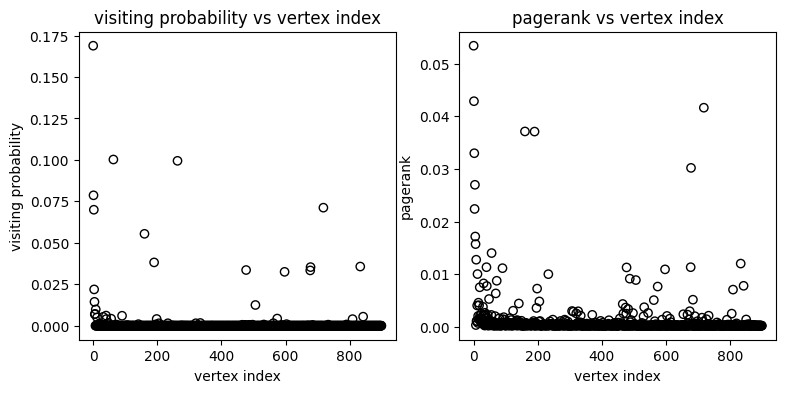

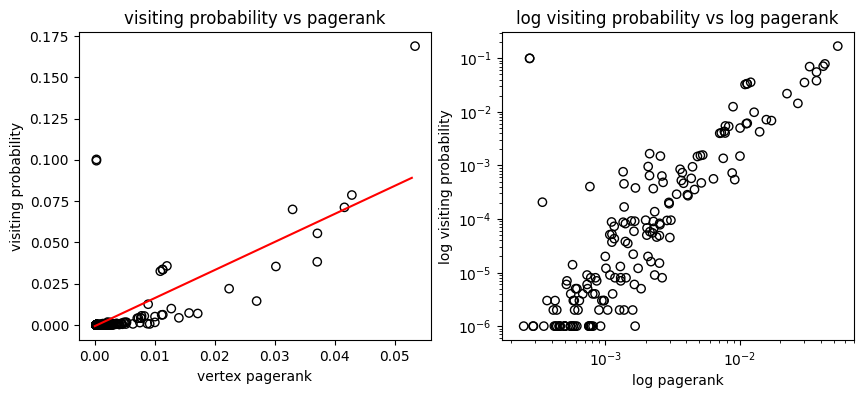

In [ ]:
analyze(rst2_4b, g2_4, mode='pagerank')

## 2.4(c) self-reinforcement pagerank 

In [ ]:
def self_rnfm_pagerank_transition_probs(g, node1, node2):
    N = g.vcount()
    pagerank_score = ig.Graph.personalized_pagerank(g, damping=0.8, 
                                                reset_vertices=[node1, node2])
    # generate transition probs 
    transition_probs = [[0] * N for i in range(N)]
    for i in range(N):
        neighbors = g.neighbors(i, mode='out')
        assert len(neighbors) > 0
        for j in neighbors:
            transition_probs[i][j] = pagerank_score[j]
    return transition_probs


# walk with prob of teleportation
T = 1000
pout = 0.2
starter = np.random.randint(0, N-1, size=(T,))  # T random starter
rst2_4c = []

# find median index
pagerank_score = ig.Graph.pagerank(g2_4, damping=0.8)
node1 = np.argsort(pagerank_score)[(N-1)//2]
node2 = np.argsort(pagerank_score)[(N+1)//2]

selfrf_per_trans_p = self_rnfm_pagerank_transition_probs(g2_4, node1, node2)


for i in range(T):
    # walk T times, add visited vertice to rst, except for the starter
    rst2_4c.append(personalized_random_walk_2(selfrf_per_trans_p, starter[i], T,
                                              pout, outnodes=[node1,node2])[1:])

nums of visited vertices is 1000000
8 top visit probability index [  0 263  63   2 718   1 160 833]
8 top personalized_pagerank index [ 63 263   0   2   1 718 190 160]
PearsonRResult(statistic=0.9111862862289627, pvalue=0.0)
PearsonRResult(statistic=0.8012278820525658, pvalue=1.7103653549278437e-202)


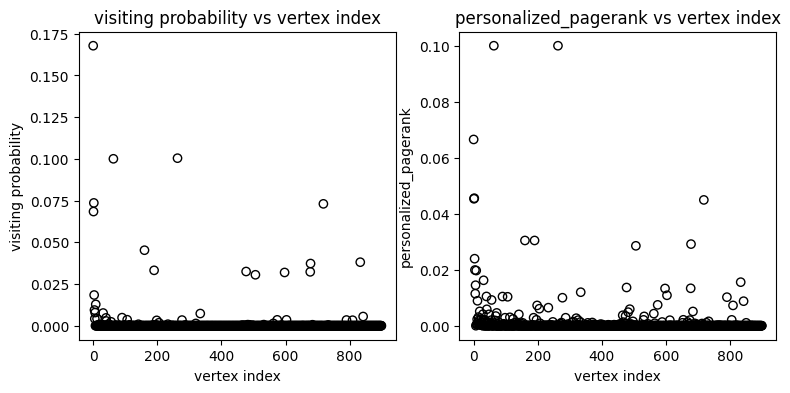

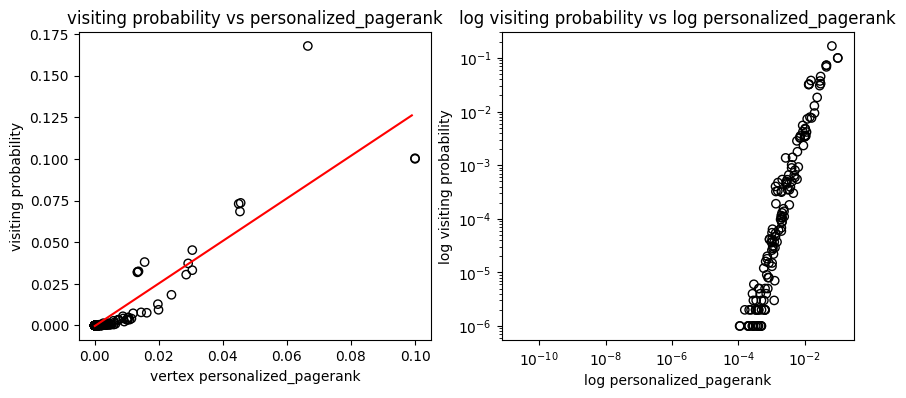

In [ ]:
analyze(rst2_4c, g2_4, mode="personalized_pagerank", nodes=[node1, node2])